In [134]:
import sys
import datetime

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")

In [ ]:
from src.corpus_utils import create_perc_dict, get_letter_frequencies
from src.cipher_utils import create_encryption_dict, encode
from src.mcmc import cross_validation, eval_solutions, eval_close_solutions, score_likelihood, is_close_solution, eval_numeric_solutions, is_numeric_solution

In [136]:
texts = [
    "The cat blinked. Sun warmed the rug. It stretched, it purred, and dreamed of birds beyond the glass.".lower(),
    "The cat curled in the clock shop, surrounded by ticking. It watched as the clockmaker worked late into the night. One the flick of its tail adjusted a gear. The chimes rang true. The cat purred and returned to its spot the guardian of time once more.".lower(),
    "The compass did point the north. The cat watched it, then leapt from the sill and followed where it led. Down the cobbled path, past forgotten gardens, to the old tower. There, a map waited. The cat touched it gently. The wind stilled. In that moment, something old and sleeping stirred. The cat stayed, pawing at the patterns. A soft hum grew beneath the earth. The villagers noticed fewer storms, calmer days. No one asked why. But all felt safer, knowing the cat still walked the edge of the wind.".lower(),
    "The cat emerged as twilight folded over the rooftops. No one knew its name, yet everyone knew of it. It slipped between shadows and chimneys, always watching. When the towns clocks began to chime out of sync and people dreamed of places they had never been, the cat stirred from its perch on the bell tower and descended. It walked the winding alleyways until it reached the librarys locked cellar. The door creaked open at its touch. Inside, the air shimmered faintly, thick with forgotten magic. The cat padded to the center, where a single thread of silver light quivered in the dark. Around it, symbols on the floor pulsed slowly, like a heartbeat. The cat blinked once, then tapped the thread with a paw. Light scattered. The symbols dimmed. Far above, stars realigned. At the dawn, the baker found the clocks ticking together again. Dreams returned to normal. No one knew why. The cat, curled in a patch of sun on the windowsill, stretched and dozed, duty fulfilled for now. The story ends here".lower()
]

In [137]:
n_texts = len(texts)
text_lengths = [len(text) for text in texts]
for i in range(len(texts)):
    print(f"Text {i+1} length: {text_lengths[i]}")

Text 1 length: 100
Text 2 length: 250
Text 3 length: 500
Text 4 length: 1000


In [138]:
corpus_lengths = [100000, 250000, 1000000, 5000000, 20000000]
n_corpuses = len(corpus_lengths)
perc_dicts = [{}] * n_corpuses

In [139]:
with open("../data/en_corpus.txt") as file:
    corpus = file.read()

for i in range(n_corpuses):
    print(f"Creating perc_dict for corpus slice of length: {corpus_lengths[i]}")
    perc_dicts[i] = create_perc_dict(corpus[:corpus_lengths[i]])

del corpus

Creating perc_dict for corpus slice of length: 100000
Creating perc_dict for corpus slice of length: 250000
Creating perc_dict for corpus slice of length: 1000000
Creating perc_dict for corpus slice of length: 5000000
Creating perc_dict for corpus slice of length: 20000000


In [ ]:
encryption_dict = create_encryption_dict()
attempts = 50
iters = 25000

encoded_texts = [encode(text, encryption_dict) for text in texts]

In [ ]:
results = {}
for encoded_text in encoded_texts:
    text_len = len(encoded_text)
    results[text_len] = {}
    for idx, perc_dict in enumerate(perc_dicts):
        corpus_len = corpus_lengths[idx]
        print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] Running cross validation for text length {text_len} and corpus length {corpus_len}.")
        samples, scores = cross_validation(attempts, encoded_text, perc_dict, iters)
        results[text_len][corpus_len] = {}
        results[text_len][corpus_len]["samples"] = samples
        results[text_len][corpus_len]["scores"] = scores

[17:22:50] Running cross validation for text length 100 and corpus length 100000.
[17:24:16] Running cross validation for text length 100 and corpus length 250000.
[17:25:30] Running cross validation for text length 100 and corpus length 1000000.
[17:26:42] Running cross validation for text length 100 and corpus length 5000000.
[17:27:55] Running cross validation for text length 100 and corpus length 20000000.
[17:29:06] Running cross validation for text length 250 and corpus length 100000.
[17:31:29] Running cross validation for text length 250 and corpus length 250000.
[17:33:50] Running cross validation for text length 250 and corpus length 1000000.
[17:36:13] Running cross validation for text length 250 and corpus length 5000000.
[17:38:30] Running cross validation for text length 250 and corpus length 20000000.
[17:40:54] Running cross validation for text length 500 and corpus length 100000.
[17:45:25] Running cross validation for text length 500 and corpus length 250000.
[17:49:4

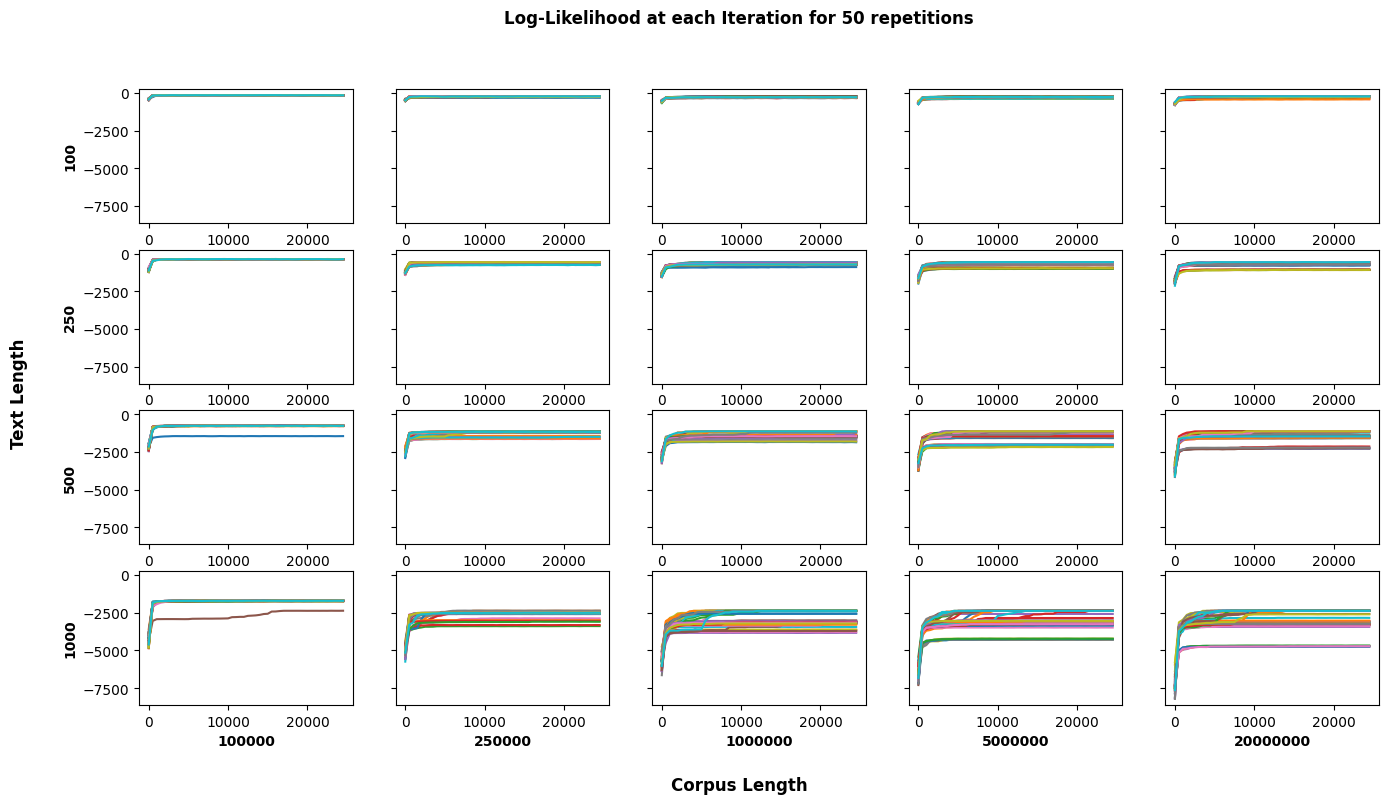

In [ ]:
range_iters = list(range(0, iters+1, 500))

fig, axes = plt.subplots(n_texts, n_corpuses, figsize=(16, 8), sharey=True)
fig.suptitle(f"Log-Likelihood at each Iteration for {attempts} repetitions", fontweight="bold")

for i in range(n_texts):
    for j in range(n_corpuses):
        text_len = text_lengths[i]
        corpus_len = corpus_lengths[j]
        scores = results[text_len][corpus_len]["scores"]
        ax = axes[i, j]

        if i == n_texts - 1:
            ax.set_xlabel(str(corpus_len), fontweight="bold")
        if j == 0:
            ax.set_ylabel(str(text_len), fontweight="bold")
        
        for k in range(len(scores)):
            ax.plot(range_iters, scores[k])

fig.text(0.5, 0.01, 'Corpus Length', ha='center', va='center', fontsize=12, fontweight="bold")
fig.text(0.05, 0.5, 'Text Length', ha='center', va='center', rotation='vertical', fontsize=12, fontweight="bold")

plt.show()

In [216]:
correct_ratios = np.empty((n_texts, n_corpuses))
close_ratios = np.empty((n_texts, n_corpuses))
numeric_ratios = np.empty((n_texts, n_corpuses))

for i in range(n_texts):
    for j in range(n_corpuses):
        text_len = text_lengths[i]
        corpus_len = corpus_lengths[j]
        solutions = results[text_len][corpus_len]["samples"]

        correct_ratio = eval_solutions(texts[i], solutions)
        close_ratio = eval_close_solutions(texts[i], solutions, perc_dicts[j])
        numerish_ratio = eval_numeric_solutions(solutions)

        correct_ratios[i][j] = correct_ratio
        close_ratios[i][j] = close_ratio
        numeric_ratios[i][j] = numerish_ratio

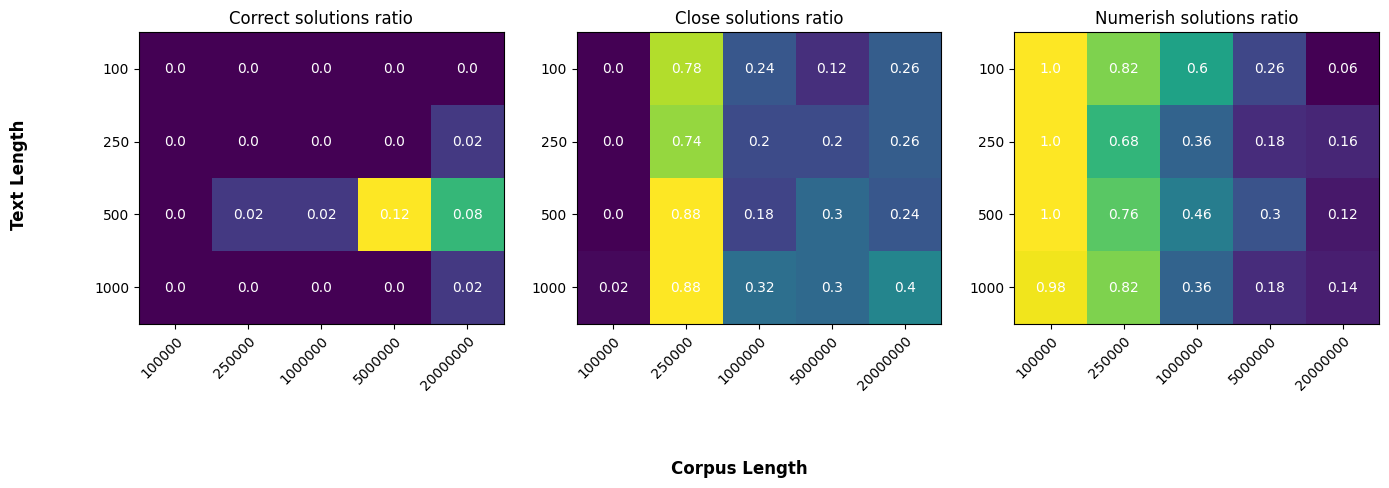

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

ax1.imshow(correct_ratios)
ax2.imshow(close_ratios)
ax3.imshow(numeric_ratios)

ax1.set_xticks(range(n_corpuses), labels=corpus_lengths, rotation=45, ha="right", rotation_mode="anchor")
ax1.set_yticks(range(n_texts), labels=text_lengths)

ax2.set_xticks(range(n_corpuses), labels=corpus_lengths, rotation=45, ha="right", rotation_mode="anchor")
ax2.set_yticks(range(n_texts), labels=text_lengths)

ax3.set_xticks(range(n_corpuses), labels=corpus_lengths, rotation=45, ha="right", rotation_mode="anchor")
ax3.set_yticks(range(n_texts), labels=text_lengths)

for i in range(n_texts):
    for j in range(n_corpuses):
        ax1.text(j, i, correct_ratios[i, j], ha="center", va="center", color="w")
        ax2.text(j, i, close_ratios[i, j], ha="center", va="center", color="w") 
        ax3.text(j, i, numeric_ratios[i, j], ha="center", va="center", color="w") 

ax1.set_title("Correct solutions ratio")
ax2.set_title("Close solutions ratio")
ax3.set_title("Numeric solutions ratio")

fig.text(0.5, 0.01, 'Corpus Length', ha='center', va='center', fontsize=12, fontweight="bold")
fig.text(0.05, 0.5, 'Text Length', ha='center', va='center', rotation='vertical', fontsize=12, fontweight="bold")
plt.show()

In [218]:
print("Original texts likelihood scores for corpus length 250000:\n")
for i in range(n_texts):
    print(f"Text {i+1} (length {text_lengths[i]}): {score_likelihood(texts[i], perc_dicts[1])}")

Original texts likelihood scores for corpus length 250000:

Text 1 (length 100): -230.07881223863208
Text 2 (length 250): -568.079373515895
Text 3 (length 500): -1127.8941837789923
Text 4 (length 1000): -2379.668528305002


In [230]:
def print_decodings(text_len: int, corpus_len: int, samples_to_show: int = 10):
    text_idx = text_lengths.index(text_len)
    corpus_idx = corpus_lengths.index(corpus_len)
    perc_dict = perc_dicts[corpus_idx]
    score = score_likelihood(texts[text_idx], perc_dict)
    print(f"Decoded texts for text length {text_len} and corpus length {corpus_len}. Original text score: {score}\n")
    for i in range(samples_to_show):
        solution = results[text_len][corpus_len]["samples"][i]
        close_msg = "close" if is_close_solution(texts[text_idx], solution, perc_dict) else "far"
        numeric_msg = "numeric" if is_numeric_solution(solution) else "non numeric"
        print(f"Attempt {i+1} (score: {score_likelihood(solution, perc_dict)}, {close_msg}, {numeric_msg})")
        print(f"{solution}\n")

In [233]:
print_decodings(text_len=250, corpus_len=250000, samples_to_show=5)

Decoded texts for text length 250 and corpus length 250000. Original text score: -568.079373515895

Attempt 1 (score: -569.6864837028172, close, numeric)
?64!18?!1q7043!52!?64!10;19!:6; w!:q77;q2343!ig!?51952.x!5?!b8?1643!8:!?64!10;19z8947!b;7943!08?4!52?;!?64!25.6?x!;24!?64!j0519!;j!5?:!?850!83cq:?43!8!.487x!?64!165z4:!782.!?7q4x!?64!18?! q7743!823!74?q7243!?;!5?:!: ;?!?64!.q873582!;j!?5z4!;214!z;74x

Attempt 2 (score: -586.1265900602115, close, numeric)
75!?197?1 28!;?43?75!?18610?q56fu?q 226 3;!;?iv?741043.:?47?,9715!;?9q?75!?18610z90!2?,620!;?897!?4376?75!?34.57:?63!?75!?j8410?6j?47q?7948?9;g q7!;?9?.!92:?75!?154z!q?293.?72 !:?75!?197?f 22!;?93;?2!7 23!;?76?47q?qf67?75!?. 92;493?6j?74z!?631!?z62!:

Attempt 3 (score: -570.4397724419898, close, numeric)
?47!65?!619072!;8!?47!6036q!:43 o!:199318272!nd!?;6q;8zj!;?!v5?6472!5:!?47!6036qx5q79!v39q72!05?7!;8?3!?47!8;z4?j!387!?47!.0;6q!3.!;?:!?5;0!52,1:?72!5!z759j!?47!64;x7:!958z!?917j!?47!65?! 19972!582!97?19872!?3!;?:!: 3?!?47!z1592;58!3.

In [235]:
print_decodings(text_len=1000, corpus_len=100000, samples_to_show=5)

Decoded texts for text length 1000 and corpus length 100000. Original text score: -2376.434538286289

Attempt 1 (score: -1723.0594425526099, far, numeric)
?6!714?7!m!0,!;74:7?9535,6?7j23;!;72k!07?6!7022j?2x:q782728!7z8!975?:784m!.7y!?7!k!0y28!7z8!972j75?q75?7:35xx!;7p!?9!!87:64;29:748;7165m8!y:.74394y:794?1658,q796!87?6!7?298:71321z:7p!,487?27165m!72v?72j7:y81748;7x!2x3!7;0!4m!;72j7x341!:7?6!y764;78!k!07p!!8.7?6!714?7:?500!;7j02m75?:7x!0167287?6!7p!337?29!0748;7;!:1!8;!;q75?7943z!;7?6!7958;58,7433!y94y:7v8?5375?70!416!;7?6!735p040y:7321z!;71!3340q7?6!7;220710!4z!;72x!874?75?:7?2v16q758:5;!.7?6!74507:65mm!0!;7j458?3y.7?651z795?67j20,2??!87m4,51q7?6!714?7x4;;!;7?27?6!71!8?!0.796!0!747:58,3!7?60!4;72j7:53k!0735,6?7iv5k!0!;7587?6!7;40zq7402v8;75?.7:ymp23:7287?6!7j32207xv3:!;7:3293y.735z!7476!40?p!4?q7?6!714?7p358z!;7281!.7?6!87?4xx!;7?6!7?60!4;795?6747x49q735,6?7:14??!0!;q7?6!7:ymp23:7;5mm!;q7j4074p2k!.7:?40:70!435,8!;q74?7?6!7;498.7?6!7p4z!07j2v8;7?6!71321z:7?51z58,7?2,!?6!074,458q7;0!4m:

In [236]:
print_decodings(text_len=1000, corpus_len=250000, samples_to_show=5)

Decoded texts for text length 1000 and corpus length 250000. Original text score: -2379.668528305002

Attempt 1 (score: -2522.5698395165537, close, numeric)
75!?187?!z!;j!3?86?7:494j57?.093!3?0k!;?75!?;00.70f6q?20?02!?,2!:?476?28z!p?x!7?!k!;x02!?,2!:?0.?47q?47?694ff!3?v!7:!!2?65830:6?823?154z2!x6p?89:8x6?:871542jq?:5!2?75!?70:26?1901,6?v!j82?70?154z!?0 7?0.?6x21?823?f!0f9!?3;!8z!3?0.?f981!6?75!x?583?2!k!;?v!!2p?75!?187?674;;!3?.;0z?476?f!;15?02?75!?v!99?70:!;?823?3!61!23!3q?47?:89,!3?75!?:42342j?899!x:8x6? 2749?47?;!815!3?75!?94v;8;x6?901,!3?1!998;q?75!?300;?1;!8,!3?0f!2?87?476?70 15q?42643!p?75!?84;?654zz!;!3?.84279xp?7541,?:475?.0;j077!2?z8j41q?75!?187?f833!3?70?75!?1!27!;p?:5!;!?8?642j9!?75;!83?0.?649k!;?94j57?y 4k!;!3?42?75!?38;,q?8;0 23?47p?6xzv096?02?75!?.900;?f 96!3?690:9xp?94,!?8?5!8;7v!87q?75!?187?v942,!3?021!p?75!2?78ff!3?75!?75;!83?:475?8?f8:q?94j57?61877!;!3q?75!?6xzv096?34zz!3q?.8;?8v0k!p?678;6?;!894j2!3q?87?75!?38:2p?75!?v8,!;?.0 23?75!?1901,6?741,42j?70j!75!;?8j842q?3;!8

The shorter the corpus is, the more numeric solutions. They tend to have lower likelihood score than original text. It makes almost imposible to find correct decoding then.